In [41]:
#--- Load necessary libraries
library(data.table)
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)
library(GenomicFeatures)
library(plyr)
library(mixtools)
options(warn=1) # print any warnings
library(zoom)

## Check for ./tsg_annotation.rda

In [3]:
if(file.exists("./tsg_annotation.rda")) {
    cat("TSG annotation data file exists, skip to Analysis\n")
} else {
    cat("TSG annotation must be created")
}

TSG annotation data file exists, skip to Analysis


# Analysis below is still in progress


In the analysis below, we map the density of endonuclease sites over the sequence of the PTPRD gene using a moving average method.

We will use the GenomicFeatures library to create a data structure from the locally stored hg38 GFF3 file.

In [4]:
txdb <- makeTxDbFromGFF("../Data/humangenome/Homo_sapiens.GRCh38.89.gff3")
exonsByGene <- exonsBy(txdb,by="gene")

Import genomic features from the file as a GRanges object ... 

In [ ]:
save(txdb,exonsByGene,file="./txdb.rda")

In [34]:
load("./tsg_annotation.rda")
source("../dev/mapSeq_SV.r")
PTPRD <- tsgs[[2]]
tmp<- mapSeq_SV(PTPRD)

Compute the coordinates of each EN site in the gene, and its Snap-Velcro state.

In [35]:
en_movingav <- function(sequence, halfWin, step) {
    #halfWin <- 100000
    #step <- 1000
    en_signal <- matrix(nrow=floor(length(sequence)/step),ncol=4)
    x_vals <- array(0,dim=c(1,floor(length(sequence)/step)))
    i<-halfWin+1
    j<-1
    while (i+halfWin < length(sequence)) {
        tmp_s   <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,1]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,2]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,3]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,4]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        x_vals[j] = i
        i <- i+step
        j<-j+1
    }
    return(list(en_signal,x_vals))
}

In [36]:
ptm <- proc.time()
enSig <- en_movingav(PTPRD,1000,500)
proc.time() - ptm

   user  system elapsed 
 77.432   0.016  77.445 

In [25]:
load("./txdb.rda")
PTPRD_start <- 8314246
exonsByGene$PTPRD
ones = array(0,dim=c(length(PTPRD),1))
for (i in 1:length(exonsByGene$PTPRD)) {
    ones[start(exonsByGene$PTPRD)[i]-PTPRD_start:end(exonsByGene$PTPRD)[i]-PTPRD_start]=1
}

GRanges object with 66 ranges and 2 metadata columns:
       seqnames               ranges strand   |   exon_id       exon_name
          <Rle>            <IRanges>  <Rle>   | <integer>     <character>
   [1]        9   [8314246, 8317942]      -   |    182533 ENSE00001254378
   [2]        9   [8314247, 8317942]      -   |    182534 ENSE00002267803
   [3]        9   [8317277, 8317471]      -   |    182535 ENSE00002227125
   [4]        9   [8317404, 8317942]      -   |    182536 ENSE00001857583
   [5]        9   [8317405, 8317942]      -   |    182537 ENSE00001952611
   ...      ...                  ...    ... ...       ...             ...
  [62]        9 [ 9938507,  9938610]      -   |    182596 ENSE00001811856
  [63]        9 [10033718, 10033790]      -   |    182597 ENSE00001895238
  [64]        9 [10340963, 10341017]      -   |    182598 ENSE00001845659
  [65]        9 [10612398, 10612505]      -   |    182599 ENSE00001824156
  [66]        9 [10612688, 10612723]      -   |    182600 

In [38]:
PTPRD_start <- 8314246
tmp<-read.table("./PTPRD_exons.csv",sep=",")
tmp<-tmp-PTPRD_start
names(tmp)<-c('start','end')

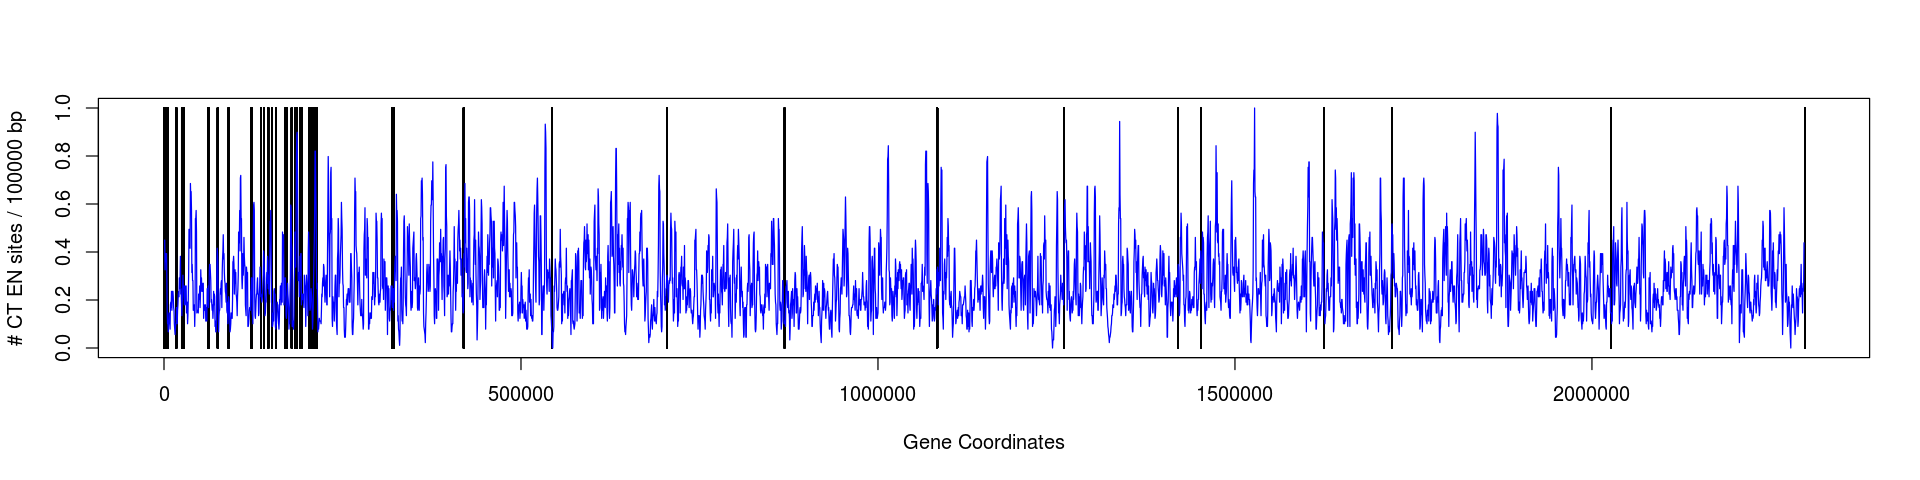

In [53]:
options(repr.plot.width=16, repr.plot.height=4)
normsig<-enSig[[1]][,1]/max(enSig[[1]][which(!is.na(enSig[[1]][,1])),1])
matplot(enSig[[2]],t(normsig),type="n",xlab="Gene Coordinates",ylab="# CT EN sites / 100000 bp",ylim=c(0,1))
for (ii in 1:nrow(tmp)) {
    range <- tmp$start[ii]:tmp$end[ii]
    lines(range,array(1,dim=c(length(range),1)),type="h")
}
lines(enSig[[2]],normsig,col="blue")